## Simpler Multi-GPU ETL using Dask ##

A major focus of the last several RAPIDS releases is easier scaling: up *and* out.

While we introduced examples of multi-gpu/multi-node data processing using Dask in our first release, it was difficult to install, configure, and launch.

Running our main example, the [Mortgage Workflow](https://github.com/rapidsai/notebooks-contrib/blob/master/intermediate_notebooks/E2E/mortgage/mortgage_e2e.ipynb) required:

1. Pre-splitting or downloading pre-split datasets
2. Using a [custom shell script](https://github.com/rapidsai/notebooks/blob/master/utils/dask-setup.sh) to:
    * Check for and force shut-down of existing dask clusters
    * Set environment variables
    * Launch dask-scheduler and dask-worker processes
3. Make limited use of Dask, only via the [`delayed` interface](http://docs.dask.org/en/latest/delayed.html)

Since our first release, we've created the [dask-cuda project](https://github.com/rapidsai/dask-cuda), which automatically handles configuring Dask worker processes to make use of available GPUs.

We also improved [dask-cudf](https://github.com/rapidsai/cudf/tree/branch-0.10/python/dask_cudf) to support a variety of common ETL operations. While joins and groupbys received the most attention, dask-cudf now also supports friendlier parallel IO.

The rest of this notebook demonstrates how we've addressed the above pains, and generally made scaling RAPIDS out to multiple-GPUs easier.

First, let's see what GPUs we have available...

In [1]:
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster
import dask, dask_cudf
from dask.diagnostics import ProgressBar

# Use dask-cuda to start one worker per GPU on a single-node system
# When you shutdown this notebook kernel, the Dask cluster also shuts down.
cluster = LocalCUDACluster(ip='0.0.0.0')
client = Client(cluster)
# print client info
client

Client Scheduler: tcp://172.17.0.2:32975 Dashboard: http://172.17.0.2:8787/status,Cluster Workers: 2 Cores: 2 Memory: 33.39 GB


Ok, we've got a cluster of GPU workers. Notice also the link to the Dask status dashboard. It provides lots of useful information while running data processing tasks.

## Accessing Data

Now, let's download a dataset.

If you're working on a local machine, you'd normally use wget, Python's `urllib` package, or another tool to pull down the data you want to analyze.

Below we use urllib to download 20 years of weather records, and a metadata file about the stations that recorded it.

In [2]:
import os
import urllib.request

data_dir = '/data/weather/'

# download weather observations
base_url = 'ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/'
years = list(range(2000, 2020))
for year in years:
    fn = str(year) + '.csv.gz'
    if not os.path.isfile(data_dir+fn):
        print(f'Downloading {base_url+fn} to {data_dir+fn}')
        urllib.request.urlretrieve(base_url+fn, data_dir+fn)
        
# download weather station metadata
station_meta_url = 'https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt'
if not os.path.isfile(data_dir+'ghcnd-stations.txt'):
    print('Downloading station meta..')
    urllib.request.urlretrieve(station_meta_url, data_dir+'ghcnd-stations.txt')

## Alternatives to Pre-Downloading Data

While downloading or copying data to your local environment is a good way to get started, many users will want other options:

1. Reading directly from distributed storage, like HDFS
2. Reading from cloud storage (S3, GCS, ADLS, etc)

See [Dask Remote Data Services](http://docs.dask.org/en/latest/remote-data-services.html) for more details on supported providers, authentication, and other storage configuration options.

Here's an example of reading the same weather data, conveniently available in a public Amazon S3 bucket.

But first make sure your Python environment has the right packages to read from your storage system of choice.

For this example: ```conda install -y s3fs```

In [3]:
# these CSV files don't have headers, we specify column names manually
names = ["station_id", "date", "type", "val"]
# there are more fields, but only the first 4 are relevant in this notebook
usecols = names[0:4]

url = 's3://noaa-ghcn-pds/csv/1788.csv'
dask_cudf.read_csv(url, names=names, usecols=usecols, storage_options={'anon': True})

,station_id,date,type,val
npartitions=1,,,,
,object,int64,object,int64
,...,...,...,...


##  Reading Large & Multi-File DataSets

Wait... there are many weather files: one for each year going back to the 1780s.

Before RAPIDS 0.6, if you wanted to read all these files in, you'd need to either use a for-loop, manually concatenating dataframes, or use [`dask.delayed`](http://docs.dask.org/en/latest/delayed.html) functions that invoke cuDF.read_csv.

Fortunately, now there's `dask_cudf.read_csv`, which supports file globs, _and_ automatically splits files into chunks that can be processed serially when needed, so you're less likely to run out of memory.

When you call `dask_cudf.read_csv`, Dask reads metadata for each CSV file and tasks workers with lists of filenames & byte-ranges that they're responsible for loading with cuDF's GPU CSV reader.

*Note*: compressed files are not splittable on read, but you can [repartition](https://docs.dask.org/en/latest/dataframe-best-practices.html#repartition-to-reduce-overhead) them downstream.

In [4]:
weather_ddf = dask_cudf.read_csv(data_dir+'*.csv.gz', names=names, usecols=usecols, compression='gzip')

/conda/envs/rapids/lib/python3.7/site-packages/dask_cudf-0.10.0a0+1081.g485a511ad-py3.7.egg/dask_cudf/io/csv.py:44: UserWarning: Warning gzip compression does not support breaking apart files
Please ensure that each individual file can fit in memory and
use the keyword ``chunksize=None to remove this message``
Setting ``chunksize=(size of file)``
  "Setting ``chunksize=(size of file)``" % compression


## Let's Process Some Data

Per the [readme](https://docs.opendata.aws/noaa-ghcn-pds/readme.html) for this dataset, multiple types of weather observations are in the same files, and each carries a different units of measure:

| Observation Type  | Existing Units | Action |
| ------------- | ------------- | ------------- |
| PRCP | Precipitation (tenths of mm) | convert to inches |
| SNWD | Snow depth (mm) | convert to inches |
| TMAX | tenths of degrees C | convert to fahrenheit |
| TMIN | tenths of degrees C | convert to fahrenheit |

There are more even more observation types, each with their own units of measure, but I wont list them all. In this notebook, I'm going to focus specifically on precipitation.

The `type` column tells us what kind of weather observation each record represents. Ordinarily, you might use `query` to filter out subsets of records and apply different logic to each subset. However, [query doesn't support string datatypes yet](https://github.com/rapidsai/cudf/issues/111). Instead, you can use boolean indexing.

For numeric types, Dask with cuDF works mostly like regular Dask. For instance, you can define new columns as combinations of other columns:

In [5]:
precip_index = weather_ddf['type'] == 'PRCP'
precip_ddf = weather_ddf[precip_index]

# convert 10ths of mm to inches
mm_to_inches = 0.0393701
precip_ddf['val'] = precip_ddf['val'] * 1/10 * mm_to_inches

Note: Calling .head() will read the first few rows, usually from the first partition.

In our case, the first partition represents weather data from 1788. Apparently, there wasn't _any_ precipitation data collected that year:

Beware in your own analyes, that you .head() from partitions that you haven't already filtered everything out of!

In [6]:
precip_ddf.get_partition(1).head()

,station_id,date,type,val
4,GM000010962,17890101,PRCP,0.015748
9,GM000010962,17890102,PRCP,0.059055
14,GM000010962,17890103,PRCP,0.066929
19,GM000010962,17890104,PRCP,0.000000
24,GM000010962,17890105,PRCP,0.000000


Ok, we have a lot of weather observations. Now what?

# Answering Questions With Data ##

For some reason, residents of particular cities like to lay claim to having the best, or the worst of something. For Los Angeles, it's having the worst traffic. New Yorkers and Chicagoans argue over who has the best pizza. [West Coasters argue about who has the most rain](https://twitter.com/MikeNiccoABC7/status/1105184947663396864).

Well... as a longtime Atlanta resident suffering from humidity exhaustion, I like to joke that with all the spring showers, _Atlanta_ is the new Seattle.

Does my theory hold water? Or will the data rain on my bad pun parade?

# How Can I Test My Theory?

We've already created `precip_df`, which is only the precipitation observations, but it's for all 100k weather stations, most of them no-where near Atlanta, and this is time-series data, so we'll need to aggregate over time ranges.

To get down to just Atlanta and Seattle precipitation records, we have to...

1. Extract year, month, and day from the compound "date" column, so that we can compare total rainfall across time.

2. Load up the station metadata file.

3. There's no "city" in the station metadata, so we'll do some geo-math and keep only stations near Atlanta and Seattle.

4. Use a Groupby to compare changing precipitation patterns across time

5. Use inner joins to filter the precipitation dataframe down to just Atlanta & Seattle data.

## 1. Extracting Finer Grained Date Fields

We _can_ do a bit of math to separate date parts..

In [7]:
precip_ddf['year'] = precip_ddf['date']/10000
precip_ddf['year'] = precip_ddf['year'].astype('int')

precip_ddf['month'] = (precip_ddf['date'] - precip_ddf['year']*10000)/100
precip_ddf['month'] = precip_ddf['month'].astype('int')

precip_ddf['day'] = (precip_ddf['date'] - precip_ddf['year']*10000 - precip_ddf['month']*100)
precip_ddf['day'] = precip_ddf['day'].astype('int')

precip_ddf.get_partition(1).head()

,station_id,date,type,val,year,month,day
4,GM000010962,17890101,PRCP,0.015748,1789,1,1
9,GM000010962,17890102,PRCP,0.059055,1789,1,2
14,GM000010962,17890103,PRCP,0.066929,1789,1,3
19,GM000010962,17890104,PRCP,0.000000,1789,1,4
24,GM000010962,17890105,PRCP,0.000000,1789,1,5


For this dataset, getting date parts is easier with string slicing. However, as is sometimes the case, Dask expects some aspect of cuDF's Python API to match Pandas in a way that [isn't fully compatible yet](https://github.com/rapidsai/cudf/issues/2367).

That bug will likely be resolved quickly. But, this example is a good chance to show how to workaround similar problems.

Dask has a [map_partitions](https://docs.dask.org/en/latest/dataframe-api.html#dask.dataframe.Series.map_partitions) function which will apply a given Python function to all partitions of a distributed DataFrame. When you do this on a dask_cudf df, your input is a cuDF object:

In [8]:
def get_date_parts(df):
    date_str = df['date'].astype('str')
    df['year'] = date_str.str.slice(0, 4).astype('int')
    df['month'] = date_str.str.slice(4, 6).astype('int')
    df['day'] = date_str.str.slice(6, 8).astype('int')
    return df

# any single-GPU function that works in cuDF may be called via dask.map_partitions
precip_ddf = precip_ddf.map_partitions(get_date_parts)
precip_ddf.get_partition(1).head()

,station_id,date,type,val,year,month,day
4,GM000010962,17890101,PRCP,0.015748,1789,1,1
9,GM000010962,17890102,PRCP,0.059055,1789,1,2
14,GM000010962,17890103,PRCP,0.066929,1789,1,3
19,GM000010962,17890104,PRCP,0.000000,1789,1,4
24,GM000010962,17890105,PRCP,0.000000,1789,1,5


The map_partitions pattern is also useful whenever there are cuDF specific functions without a direct mapping into Dask.

## 2. Loading Station Metadata ##

In [9]:
!head -n 5 /data/weather/ghcnd-stations.txt

ACW00011604  17.1167  -61.7833   10.1    ST JOHNS COOLIDGE FLD                       
ACW00011647  17.1333  -61.7833   19.2    ST JOHNS                                    
AE000041196  25.3330   55.5170   34.0    SHARJAH INTER. AIRP            GSN     41196
AEM00041194  25.2550   55.3640   10.4    DUBAI INTL                             41194
AEM00041217  24.4330   54.6510   26.8    ABU DHABI INTL                         41217


Wait... That's no CSV file! It's fixed-width!

That's annoying because we don't have a reader for it. We could use CPU code to pre-process the file, making it friendlier for loading into a DataFrame, but, RAPIDS is about end-to-end data processing without leaving the GPU.

This file is small enough that we can handle it directly with cuDF on a single GPU.

*Warning*: Make sure you [create your dask-cuda cluster _before_ importing cudf](https://github.com/rapidsai/dask-cuda/issues/32).

Here's how to cleanup this metadata using cuDF and string operations:

In [10]:
import cudf

fn = data_dir+'ghcnd-stations.txt'
# There are no '|' chars in the file. Use that to read the file as a single column per line
# quoting=3 handles misplaced quotes in the `name` field 
station_df = cudf.read_csv(fn, sep='|', quoting=3, names=['lines'], header=None)

# you can use normal DataFrame .str accessor, and chain operators together
station_df['station_id'] = station_df['lines'].str.slice(0, 11).str.strip()
station_df['latitude'] = station_df['lines'].str.slice(12, 20).str.strip()
station_df['longitude'] = station_df['lines'].str.slice(21, 30).str.strip()
station_df = station_df.drop('lines')

station_df.head()

,station_id,latitude,longitude
0,ACW00011604,17.1167,-61.7833
1,ACW00011647,17.1333,-61.7833
2,AE000041196,25.3330,55.5170
3,AEM00041194,25.2550,55.3640
4,AEM00041217,24.4330,54.6510


# Managing Memory

While GPU memory is very fast, there's less of it than host RAM. It's a good idea to avoid storing lots of columns that aren't useful for what you're trying to do, especially when they're strings.

For example, for the station metadata, there are more columns than we parsed out above. In this workflow we only need `station_id`, `latitude`, and `longitude`, so we skipped parsing the rest of the columns.

We also need to convert latitude and longitude from strings to floats, and convert the single-GPU DataFrame to a Dask DataFrame that can be distributed across workers.

In [11]:
# you can cast string columns to numerics
station_df['latitude'] = station_df['latitude'].astype('float')
station_df['longitude'] = station_df['longitude'].astype('float')

## 3. Filtering Weather Stations by Distance

Initially we planned to use our [existing Haversine Distance user defined function](https://medium.com/rapids-ai/user-defined-functions-in-rapids-cudf-2d7c3fc2728d) to figure out which stations are within a given distance from a city. However, that relies on a [numba CUDA JIT'ed kernel](https://numba.pydata.org/numba-doc/dev/cuda/index.html), which would be slower and would incur compilation time the first time you call it.

Now that [cuSpatial](https://github.com/rapidsai/cuspatial) is available as [a nightly conda package](https://anaconda.org/rapidsai-nightly/cuspatial), we can use it without having to build from source:

```
conda install -c conda-forge rapidsai-nightly cuspatial
```

For this scenario, we've manually looked up Atlanta and Seattle's city centers and will fill `cudf.Series` with their latitude and longitude values. Then we can call a cuSpatial function to compute the distance between each station and each city.

In [12]:
import cuspatial

# fill new Series with Atlanta lat/lng
station_df['atlanta_lat'] = 33.7490
station_df['atlanta_lng'] = -84.3880
# compute distance from each station to Atlanta
station_df['atlanta_dist'] = cuspatial.haversine_distance(
    station_df['longitude'], station_df['latitude'],
    station_df['atlanta_lng'], station_df['atlanta_lat']
)

# fill new Series with Seattle lat/lng
station_df['seattle_lat'] = 47.6219
station_df['seattle_lng'] = -122.3517
# compute distance from each station to Seattle
station_df['seattle_dist'] = cuspatial.haversine_distance(
    station_df['longitude'], station_df['latitude'],
    station_df['seattle_lng'], station_df['seattle_lat']
)

### Checking the Results

In [13]:
# Inspect the results:
atlanta_stations_df = station_df.query('atlanta_dist <= 25')
seattle_stations_df = station_df.query('seattle_dist <= 25')

print(f'Atlanta Stations: {len(atlanta_stations_df)}')
print(f'Seattle Stations: {len(seattle_stations_df)}')

atlanta_stations_df.head()

Atlanta Stations: 64
Seattle Stations: 119


,station_id,latitude,longitude,atlanta_lat,atlanta_lng,atlanta_dist,seattle_lat,seattle_lng,seattle_dist
56469,US1GACB0002,33.8939,-84.4938,33.749,-84.388,18.844744,47.6219,-122.3517,3489.923424
56471,US1GACB0004,33.9512,-84.4219,33.749,-84.388,22.700514,47.6219,-122.3517,3491.328996
56472,US1GACB0005,33.8274,-84.4988,33.749,-84.388,13.447851,47.6219,-122.3517,3494.054111
56474,US1GACB0007,33.8714,-84.5221,33.749,-84.388,18.404877,47.6219,-122.3517,3489.369691
56476,US1GACB0014,33.8907,-84.5946,33.749,-84.388,24.749221,47.6219,-122.3517,3482.751406


[Google tells me those station ids are from Smyrna](https://geographic.org/global_weather/georgia/smyrna_23_ne_002.html), a town just outside of Atlanta's perimiter. Our distance calculation worked!

## 4. Grouping & Aggregating by Time Range

Before using an inner join to filter down to city-specific precipitation data, we can use a groupby to sum the precipitation for station and year. That'll allow the join to proceed faster and use less memory.

One total precipitation record per station per year is relatively small, and we're going to need to graph this data, so we'll go ahead and `compute()` the result, asking Dask to aggregate across the 200+ years worth of data, bringing the results back to the client as a single GPU cuDF DataFrame.

Note that with Dask, data is partitioned and distributed across multiple workers. Some operations require that workers "[shuffle](http://docs.dask.org/en/latest/dataframe-groupby.html#)" data from their partitions back and forth across the network, which has major performance implications. Today join, groupby, and sort operations can be fairly network constrained.

See the [slides](https://www.slideshare.net/MatthewRocklin/ucxpython-a-flexible-communication-library-for-python-applications) from a recent talk at GTC San Jose to learn more about [ongoing efforts to integrate Dask with UCX](https://github.com/rapidsai/ucx-py/) and allow it to use accelerated networking hardware like Infiniband and [nvlink](https://www.nvidia.com/en-us/data-center/nvlink/).

In the meantime, distributed operators that require shuffling like joins, groupbys, and sorts work, albeit not as fast as we'd like.

In [14]:
precip_year_ddf = precip_ddf.groupby(by=['station_id', 'year']).val.sum()

Note that we're calling `compute` again here. This tells Dask to actually start computing the full set of processing logic defined thus far:

1. Read and decompress 232 gzipped files (about 100 GB decompressed)
2. Send to the GPU and parse
3. Filter down to precipitation records
4. Apply a conversion to inches
5. Sum total inches of rain per year per each of the 108k weather stations
6. Combine and pull results a single GPU DataFrame on the client host

To wit.. this will take time.

In [15]:
%time precip_year_df = precip_year_ddf.compute()

# Convert from the groupby multi-indexed DataFrame back to a normal DF which we can use with merge
precip_year_df = precip_year_df.reset_index()

CPU times: user 30.8 s, sys: 3.94 s, total: 34.8 s
Wall time: 6min 1s


## 5. Using Inner Joins to Filter Weather Observations

We have separate DataFrames containing Atlanta and Seattle stations, and we have our total precipitation grouped by `station_id` and `year`. Computing inner joins can let us compute total precipitation by year for just Atlanta and Seattle.

In [16]:
%time atlanta_precip_df = precip_year_df.merge(atlanta_stations_df, on=['station_id'], how='inner')

CPU times: user 95.2 ms, sys: 59.1 ms, total: 154 ms
Wall time: 140 ms


In [17]:
atlanta_precip_df.head()

,station_id,year,val,latitude,longitude,atlanta_lat,atlanta_lng,atlanta_dist,seattle_lat,seattle_lng,seattle_dist
0,USC00090444,1994,57.752000,33.8264,-84.4961,33.749,-84.388,13.186050,47.6219,-122.3517,3494.319666
1,USC00090444,2008,39.295297,33.8264,-84.4961,33.749,-84.388,13.186050,47.6219,-122.3517,3494.319666
2,USW00003888,2004,47.799238,33.7792,-84.5214,33.749,-84.388,12.780552,47.6219,-122.3517,3495.663654
3,USW00013864,1951,44.657504,33.9167,-84.5167,33.749,-84.388,22.114180,47.6219,-122.3517,3486.704646
4,USW00093830,1954,6.685043,33.8667,-84.3000,33.749,-84.388,15.407544,47.6219,-122.3517,3505.972076


In [18]:
%time seattle_precip_df = precip_year_df.merge(seattle_stations_df, on=['station_id'], how='inner')

CPU times: user 12.4 ms, sys: 7.74 ms, total: 20.1 ms
Wall time: 16.8 ms


In [19]:
seattle_precip_df.head()

,station_id,year,val,latitude,longitude,atlanta_lat,atlanta_lng,atlanta_dist,seattle_lat,seattle_lng,seattle_dist
0,US1WAKG0020,2009,23.492139,47.6510,-122.3303,33.749,-84.388,3506.598526,47.6219,-122.3517,3.611263
1,USC00457478,1942,35.456712,47.6500,-122.2833,33.749,-84.388,3503.133978,47.6219,-122.3517,6.002416
2,US1WAKP0020,2011,34.303168,47.6297,-122.5686,33.749,-84.388,3523.564356,47.6219,-122.3517,16.278042
3,USC00458802,1954,44.338607,47.4500,-122.5000,33.749,-84.388,3514.434751,47.6219,-122.3517,22.120209
4,USW00094248,1998,22.145681,47.4933,-122.2144,33.749,-84.388,3494.417784,47.6219,-122.3517,17.624732


Lastly, we need to normalize the total amount of rain in each city by the number of stations which collected rainfall: Seattle had twice as many stations collecting, but that doesn't mean more total rain fell! 

In [20]:
atlanta_rain = atlanta_precip_df.groupby(['year']).val.sum()/len(atlanta_stations_df)
atlanta_rain.head()

year
1899    0.384105
1900    0.845227
1901    0.741450
1902    0.664247
1903    0.830340
Name: val, dtype: float64

In [21]:
seattle_rain = seattle_precip_df.groupby(['year']).val.sum()/len(seattle_stations_df)

seattle_rain.head()

year
1891    0.010785
1892    0.017568
1894    0.345398
1895    0.249752
1896    0.359426
Name: val, dtype: float64

## Visualizing the Answer

To generate the graphs in the cells below, first you'll need to ```conda install -y python-graphviz matplotlib```

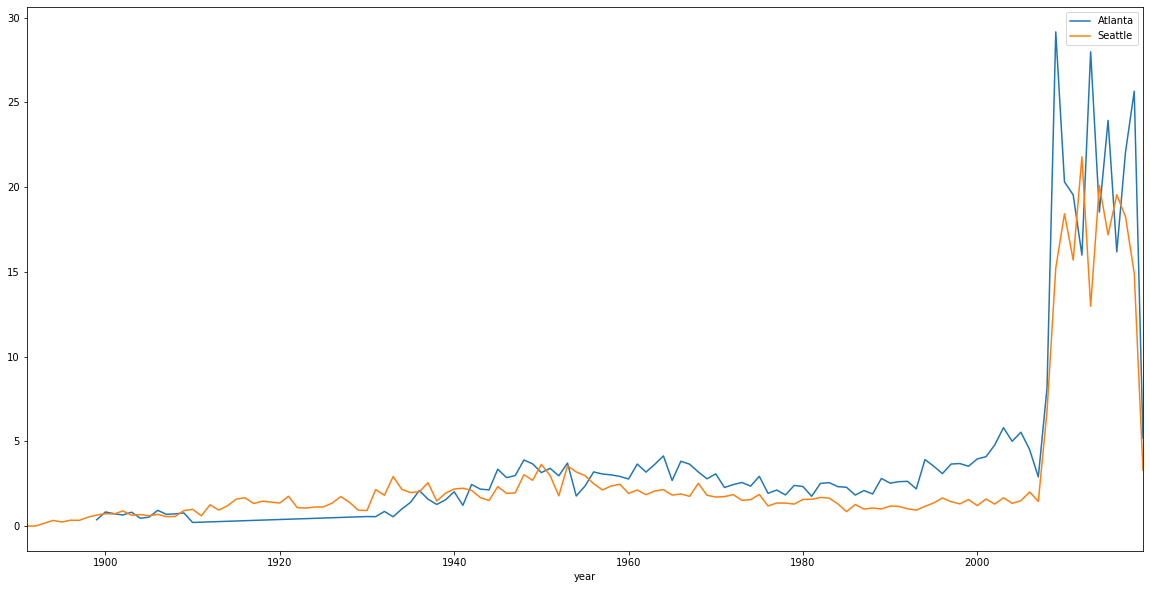

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

plt.close('all')
plt.rcParams['figure.figsize'] = [20, 10]

fig, ax = subplots()

atlanta_rain.to_pandas().plot(ax=ax)
seattle_rain.to_pandas().plot(ax=ax)

ax.legend(['Atlanta', 'Seattle'])

# Results

It looks like I'm right (mostly)! At least for roughly the last 80 years, it rains more by volume in Atlanta than it does in Seattle. The data seems to confirm my suspicions.

But as usual the answer raises additional questions:

1. Without singling out Atlanta and Seattle, which city actually has the most precipitation by volume?

2. Why is there such a large increase in observed precipitation in the last 10 years?

3. One friend noted that it rains more frequently in Seattle, just not as hard. A contrarian was quick to point out that it mists a lot in Seattle. How often is it just "misty", but not really raining?

We'll revisit these questions in a future post, and look forward to seeing what kinds of analyses YOU come up with.

# Takeaways

We just showed some of the ways you can use Dask and cuDF to parallelize typical data processing tasks on multiple GPUs. Hopefully this notebook provides useful examples to refer to while doing your own ETL & analytics work.

For more info on what's working today with Dask and cuDF, see [our summary](https://docs.rapids.ai/api/cudf/stable/), and follow [our ongoing development](https://github.com/rapidsai/cudf).

Also checkout out other [community contributed notebooks](https://github.com/rapidsai/notebooks-contrib), and submit your own!